<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Process-mining" data-toc-modified-id="Process-mining-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Process mining</a></span><ul class="toc-item"><li><span><a href="#Order-to-cash-process" data-toc-modified-id="Order-to-cash-process-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Order to cash process</a></span><ul class="toc-item"><li><span><a href="#Creation-of-new-features" data-toc-modified-id="Creation-of-new-features-1.1.1"><span class="toc-item-num">1.1.1&nbsp;&nbsp;</span>Creation of new features</a></span></li><li><span><a href="#Order-duration" data-toc-modified-id="Order-duration-1.1.2"><span class="toc-item-num">1.1.2&nbsp;&nbsp;</span>Order duration</a></span><ul class="toc-item"><li><span><a href="#Bottlenecks-identification" data-toc-modified-id="Bottlenecks-identification-1.1.2.1"><span class="toc-item-num">1.1.2.1&nbsp;&nbsp;</span>Bottlenecks identification</a></span></li></ul></li><li><span><a href="#Automation-potential" data-toc-modified-id="Automation-potential-1.1.3"><span class="toc-item-num">1.1.3&nbsp;&nbsp;</span>Automation potential</a></span></li><li><span><a href="#Rework" data-toc-modified-id="Rework-1.1.4"><span class="toc-item-num">1.1.4&nbsp;&nbsp;</span>Rework</a></span></li><li><span><a href="#Non-compliance" data-toc-modified-id="Non-compliance-1.1.5"><span class="toc-item-num">1.1.5&nbsp;&nbsp;</span>Non compliance</a></span></li></ul></li></ul></li></ul></div>

In [176]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import process_step

In [185]:
sns.set_palette('Set2')

# Process mining

**Definition** : Process mining allows to get an in-depth look at the business processes. It is made possible by the fact that most business processes are conducted via a transactional system and leave a digital trace (event logs). Valuable knowledge can be extracted from the event logs : they help create a living picture of what processes look like in practice (which may or may not match the way that processes were originally defined).

**Business need** : Process mining enables companies to figure out exactly what's happening in their processes (where things are stuck, what is working best,...) and to drive process improvement through standardizing, streamlining, optimizing and automating.

## Order to cash process

For this business case, we will focus on the 'Order-to-cash' process. The event logs have been artificially created and can be found on processminingdata.com. They have been curated to make sure real use cases can be explored.

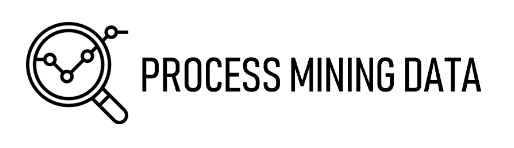

The 'order-to-cash' process encompasses all the tasks performed from the customer order to the payment.

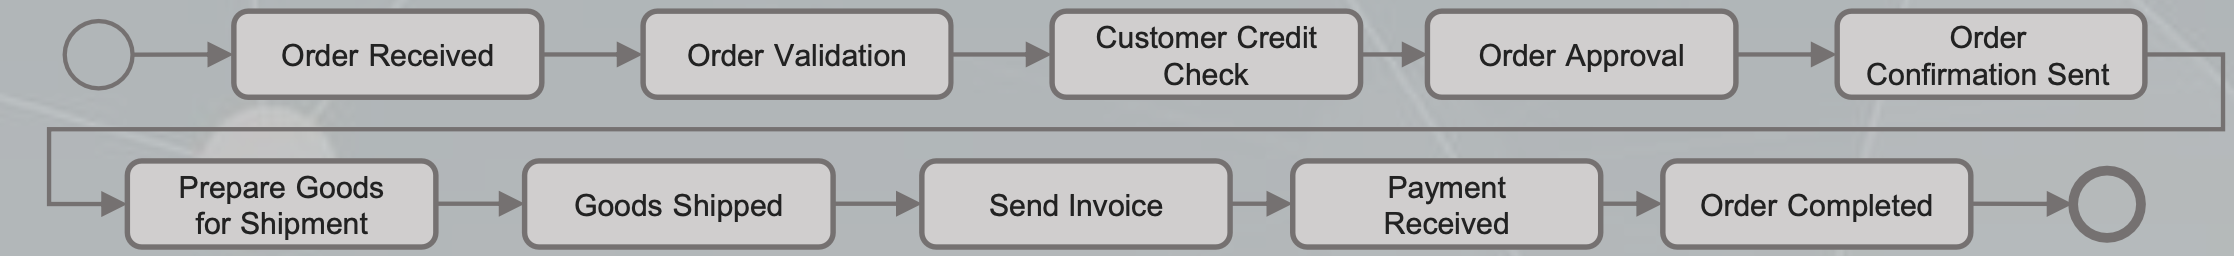

In [10]:
process_flow_ordered = ['Order Received', 'Order Validation', 'Customer Credit Check', 'Order Approval', 'Order Confirmation Sent', 'Prepare Goods for Shipment',
                'Goods Shipped', 'Send Invoice', 'Payment Received', 'Order Completed']

In [11]:
df = pd.read_csv("./Data/01. Order-to-Cash/order_to_cash_event_log_05012023.csv", sep=";", engine="python")
df.head()

,Case id,Activity name,Timestamp,Resource,User type,Resource name,Product name,Product description,Order value,Business unit,Customer name,Customer payment history
0,Order-1,Order Received,23/01/2020 0:00,Finance Department,bot,Resource A,Product E,Description B,183,Business Unit 2,Customer A,bad
1,Order-1,Order Validation,27/01/2020 0:00,Sales Department,human,Resource A,Product D,Description D,380,Business Unit 2,NaN,bad
2,Order-1,Customer Credit Check,01/02/2020 0:00,Sales Department,human,Resource A,Product D,Description E,463,Business Unit 1,NaN,bad
3,Order-1,Order Rejected,04/02/2020 0:00,Sales Department,bot,Resource A,Product D,Description D,195,Business Unit 3,NaN,bad
4,Order-1,Order Completed,08/02/2020 0:00,Finance Department,bot,Resource A,Product A,Description A,434,Business Unit 1,NaN,bad


In [12]:
df.shape

(671424, 12)

In [13]:
nb_order = len(df['Case id'].value_counts())
print(f"There are {nb_order:,} order cases.")

There are 70,000 order cases.


In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 671424 entries, 0 to 671423
Data columns (total 12 columns):
 #   Column                    Non-Null Count   Dtype 
---  ------                    --------------   ----- 
 0   Case id                   671424 non-null  object
 1   Activity name             671424 non-null  object
 2   Timestamp                 671424 non-null  object
 3   Resource                  671424 non-null  object
 4   User type                 671424 non-null  object
 5   Resource name             671424 non-null  object
 6   Product name              671424 non-null  object
 7   Product description       671424 non-null  object
 8   Order value               671424 non-null  int64 
 9   Business unit             671424 non-null  object
 10  Customer name             70000 non-null   object
 11  Customer payment history  671424 non-null  object
dtypes: int64(1), object(11)
memory usage: 61.5+ MB


In [15]:
df["Timestamp"] = pd.to_datetime(df["Timestamp"], format='%d/%m/%Y %H:%M') # change to timestamp to be able to treat as date/time
df = df.sort_values(by=["Case id", "Timestamp"]) # order by order case and by timestamp to follow the order of each step

In [85]:
delta = df["Timestamp"].max() - df["Timestamp"].min()
print(f'The event logs cover {delta.days} working days.')

The event logs cover 397 working days.


### Creation of new features

In [17]:
# duration of each process step (in days)
df['duration'] = np.where(df['Case id']==df['Case id'].shift(1), (df['Timestamp'] - df['Timestamp'].shift(1))/ np.timedelta64(1,'D'),0)

# day of the week the process was executed
df['day_week'] = df['Timestamp'].dt.day_name()

# warning if the process was made during the weekend by a human (should not happen)
df['warning_day'] = np.where((df['User type']!='bot') & ((df['day_week']=='Saturday') | (df['day_week']=='Sunday')), 1, 0)

# warning if the order was approved but the client had a bad history (should not happen)
df['warning_app'] = np.where((df['Activity name']=='Order Approval') & (df['Customer payment history']=='bad'), 1, 0)

# number of step in each order case
steps = pd.DataFrame(df.groupby(['Case id'])['Activity name'].count())
steps.reset_index(inplace=True)
steps.rename(columns={'Activity name':'nb_steps'}, inplace=True)
df = df.merge(steps, on='Case id')

# total duration of an order case + % taken by each process
order_duration = pd.DataFrame(df.groupby(['Case id']).duration.sum())
order_duration.reset_index(inplace=True)
order_duration.rename(columns={'duration':'order_total_duration'}, inplace=True)
df = df.merge(order_duration, on='Case id')
df['%perc_total_duration'] = df['duration']/df['order_total_duration']

# number of steps automatised by order case + % of automatisation by order case
automation = pd.DataFrame(df.groupby(['Case id'])['User type'].value_counts())
automation.reset_index(inplace=True)
automation.rename(columns={'count':'auto'}, inplace=True)
automation = automation.drop(automation[automation['User type']=='human'].index)
df = df.merge(automation[['Case id', 'auto']], on='Case id')
df['%perc_total_auto'] = df['auto']/df['nb_steps']

# this feature indicates whether the process has been done more than once for each case (duplicated process)
ind = df[df.duplicated(subset=['Case id', 'Activity name'])].index
df['duplicated_process'] = 0
df.loc[ind, 'duplicated_process'] = 1


In [8]:
##
process_flow = [['Order Received'], ['Order Validation'], ['Customer Credit Check'], ['Order Approval'], ['Order Confirmation Sent'], ['Prepare Goods for Shipment'],
                ['Goods Shipped'], ['Send Invoice'], ['Payment Received'], ['Order Completed']]

In [9]:
##
no_dup = df.groupby('Case id').duplicated_process.sum() 
ind_dup = no_dup[no_dup>0] # case with duplicate

df['diff_than_flow'] = np.where(df['nb_steps']==len(process_flow_ordered), 0, 1)
df.set_index('Case id', inplace=True)
df.loc[ind_dup.index.tolist(), 'diff_than_flow'] = 1
df.reset_index(inplace=True)

In [18]:
df.head()

,Case id,Activity name,Timestamp,Resource,User type,Resource name,Product name,Product description,Order value,Business unit,...,duration,day_week,warning_day,warning_app,nb_steps,order_total_duration,%perc_total_duration,auto,%perc_total_auto,duplicated_process
0,Order-1,Order Received,2020-01-23,Finance Department,bot,Resource A,Product E,Description B,183,Business Unit 2,...,0.0,Thursday,0,0,5,16.0,0.0000,3,0.6,0
1,Order-1,Order Validation,2020-01-27,Sales Department,human,Resource A,Product D,Description D,380,Business Unit 2,...,4.0,Monday,0,0,5,16.0,0.2500,3,0.6,0
2,Order-1,Customer Credit Check,2020-02-01,Sales Department,human,Resource A,Product D,Description E,463,Business Unit 1,...,5.0,Saturday,1,0,5,16.0,0.3125,3,0.6,0
3,Order-1,Order Rejected,2020-02-04,Sales Department,bot,Resource A,Product D,Description D,195,Business Unit 3,...,3.0,Tuesday,0,0,5,16.0,0.1875,3,0.6,0
4,Order-1,Order Completed,2020-02-08,Finance Department,bot,Resource A,Product A,Description A,434,Business Unit 1,...,4.0,Saturday,0,0,5,16.0,0.2500,3,0.6,0


### Order duration

#### Bottlenecks identification

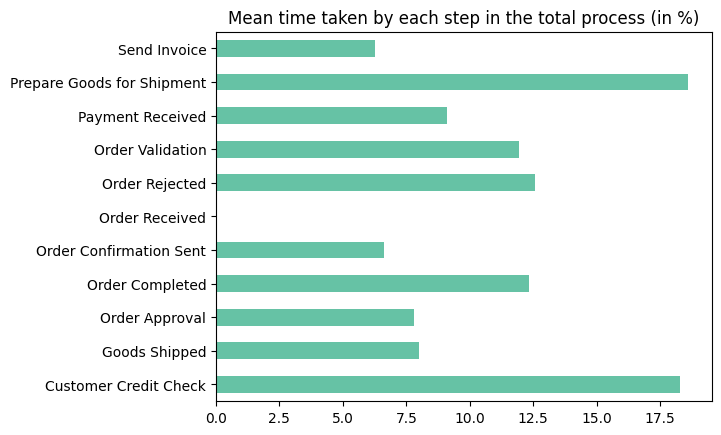

In [186]:
# 2 processes take up much of the order time : preparation of the good for shipment and the customer credit check (about 18% of the total duration)

time_process = pd.DataFrame(df.groupby("Activity name")['%perc_total_duration'].mean().mul(100))
time_process.plot.barh(title='Mean time taken by each step in the total process (in %)', legend=False)
plt.ylabel('');

In [57]:
# the longest steps take 7 days, and there are only made up of 'customer credit check' steps
max_time = df[df['duration']==df['duration'].max()]
max_time['Activity name'].value_counts()

Activity name
Customer Credit Check    2837
Name: count, dtype: int64

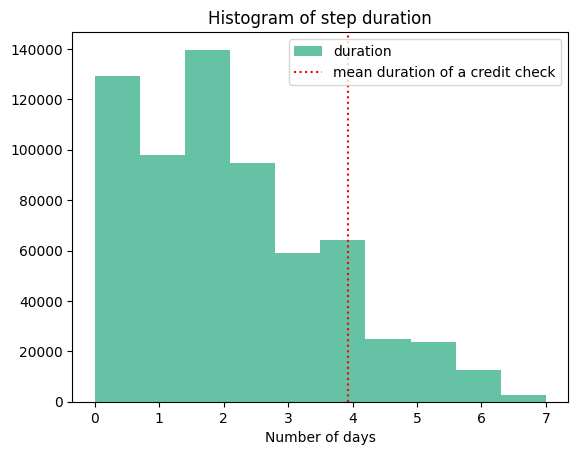

In [187]:
df['duration'].plot.hist()
x=df[df['Activity name']=='Customer Credit Check'].duration.mean()
plt.axvline(x, linestyle='dotted', color='r', label='mean duration of a credit check')
plt.title("Histogram of step duration")
plt.xlabel('Number of days')
plt.legend()
plt.ylabel('');

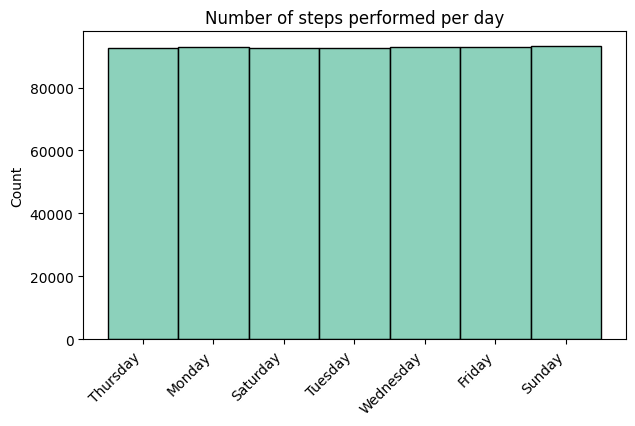

In [188]:
# this dataset has been generated by ai, which explains why all the days are working days
plt.figure(figsize=(7,4))
ax=sns.histplot(data=df, x='day_week')
plt.title('Number of steps performed per day')
plt.xticks(rotation=45, ha='right')
plt.xlabel('');

###### Credit check

In [39]:
# this activity is only done by human -> high potential of automatisation
df[df['Activity name']=='Customer Credit Check']['User type'].value_counts()

User type
human    87443
Name: count, dtype: int64

In [40]:
# this task is evenly distributed accross the days of the week (probably because it's a fake dataset)
# that employee have to work on saturdays and sundays should be a warning (should happen on specific occasion only)
df[df['Activity name']=='Customer Credit Check']['day_week'].value_counts(normalize=True).mul(100).round(2)

day_week
Monday       14.66
Saturday     14.33
Tuesday      14.23
Friday       14.23
Sunday       14.21
Thursday     14.19
Wednesday    14.15
Name: proportion, dtype: float64

In [41]:
# seems weird that credit check involves so many different services (sales and finance seem more relevant for this task)
# to be investigated
df[df['Activity name']=='Customer Credit Check']['Resource'].value_counts(normalize=True).mul(100).round(2)

Resource
Sales Department      28.80
Customer Portal       14.55
Sales Manager         14.36
Logistics Provider    14.16
Warehouse             14.15
Finance Department    13.99
Name: proportion, dtype: float64

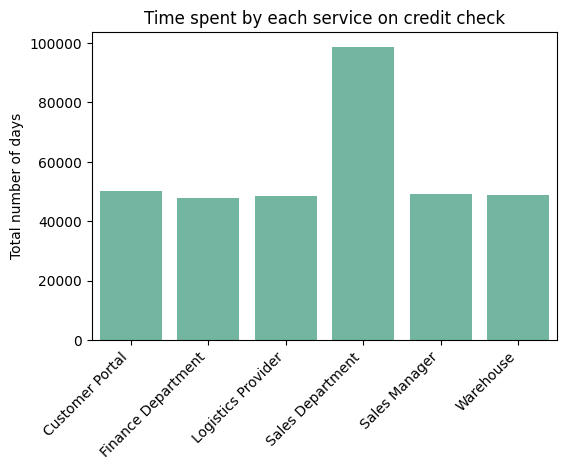

In [189]:
# it is not actually time spent, but rather how long it take to go to credit check to the next step
fig, ax = plt.subplots(figsize=(6,4))
sns.barplot(data=df[df['Activity name']=='Customer Credit Check'].groupby('Resource').sum('duration').reset_index(), x='Resource', y='duration')
ax.set_title("Time spent by each service on credit check")
ax.set_xticks(ax.get_xticks(), ax.get_xticklabels(), rotation=45, ha='right')
ax.set_xlabel("")
ax.set_ylabel("Total number of days");

###### Shipment preparation

In [89]:
# this activity is mostly done by human -> there is a potential for automatisation
df[df['Activity name']=='Prepare Goods for Shipment']['User type'].value_counts(normalize=True).mul(100).round(2)

User type
human    63.85
bot      36.15
Name: proportion, dtype: float64

In [90]:
# same remarks as above (employees should not work that much on weekends)
df[df['Activity name']=='Prepare Goods for Shipment']['day_week'].value_counts(normalize=True).mul(100).round(2)

day_week
Friday       14.49
Sunday       14.49
Thursday     14.36
Tuesday      14.26
Wednesday    14.25
Saturday     14.10
Monday       14.05
Name: proportion, dtype: float64

In [91]:
# seems weird that goods preparation would involve so many different services (warehouse and logistic provider seem the onluy releveant services)
# to be investigated
df[df['Activity name']=='Prepare Goods for Shipment']['Resource'].value_counts(normalize=True).mul(100).round(2)

Resource
Sales Department      28.75
Logistics Provider    14.37
Sales Manager         14.27
Finance Department    14.27
Warehouse             14.25
Customer Portal       14.10
Name: proportion, dtype: float64

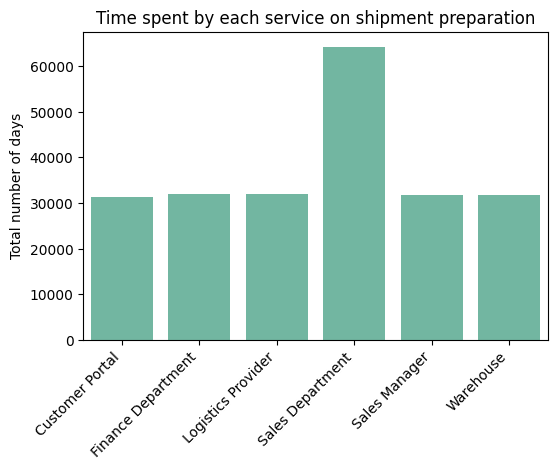

In [190]:
fig, ax = plt.subplots(figsize=(6,4))
sns.barplot(data=df[df['Activity name']=='Prepare Goods for Shipment'].groupby('Resource').sum('duration').reset_index(), x='Resource', y='duration')
ax.set_title("Time spent by each service on shipment preparation")
ax.set_xticks(ax.get_xticks(), ax.get_xticklabels(), rotation=45, ha='right')
ax.set_xlabel("")
ax.set_ylabel("Total number of days");

The sales department is involved in the 2 activities thake up the most time and in both cases, this department spends more time than the other department by far.

**To do** : further detail the different tasks performed by the sales department on both this steps & check wether there is a staff shortage.

### Automation potential

In [96]:
# 31% of the process is automated overall
df['User type'].value_counts(normalize=True).mul(100).round(2)

User type
human    68.71
bot      31.29
Name: proportion, dtype: float64

In [97]:
# average duration of a bot/human proces (in days)
# overall and on average, bots are faster
df.groupby('User type').duration.mean().round(2)

User type
bot      1.86
human    2.25
Name: duration, dtype: float64

In [133]:
# but if we look in detail, this gap is only due to the customer credit check step which is only done by human and is the longest step
# for all the other steps, bots take the same time at best as human
# most of the time, bots take longer(highlighted in red below)

automat = pd.DataFrame(df.groupby(['Activity name', 'User type']).duration.mean().round(2))
automat.sort_values(by=['Activity name', 'User type'])
automat.reset_index(inplace=True)
automat['gap bot-human'] = np.where(automat['User type']=='bot', automat['duration'].diff(-1), np.nan)
automat.style.highlight_between(subset='gap bot-human', color='red', left=0.01)

,Activity name,User type,duration,gap bot-human
0,Customer Credit Check,human,3.930000,nan
1,Goods Shipped,bot,1.620000,0.020000
2,Goods Shipped,human,1.600000,nan
3,Order Approval,bot,1.580000,0.020000
4,Order Approval,human,1.560000,nan
5,Order Completed,bot,2.440000,0.050000
6,Order Completed,human,2.390000,nan
7,Order Confirmation Sent,bot,1.410000,0.020000
8,Order Confirmation Sent,human,1.390000,nan
9,Order Received,bot,0.000000,0.000000


In [93]:
# order validation are mostly automated vs customer credit are mostly handled by human
df.groupby('User type').agg({"Activity name":pd.Series.mode})

,Activity name
User type,
bot,Order Validation
human,Customer Credit Check


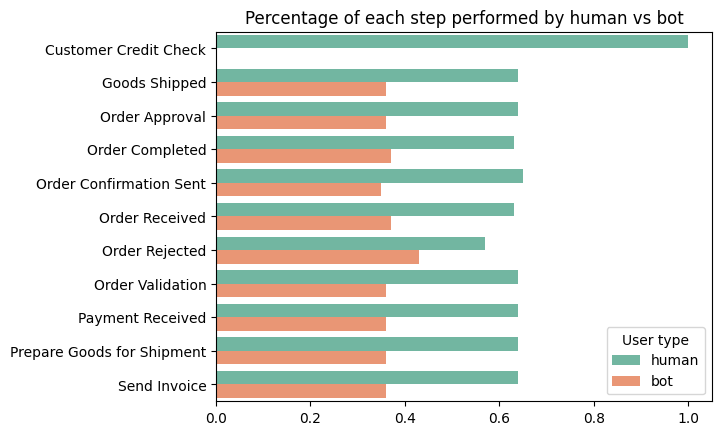

In [191]:
# automation rate per process
auto_process = pd.DataFrame(df.groupby('Activity name')['User type'].value_counts(normalize=True).round(2))
auto_process.reset_index(inplace=True)
auto_process.set_index('Activity name', inplace=True)
sns.barplot(data=auto_process, x='proportion', y='Activity name', hue='User type')
plt.xlabel('')
plt.ylabel('')
plt.title('Percentage of each step performed by human vs bot');

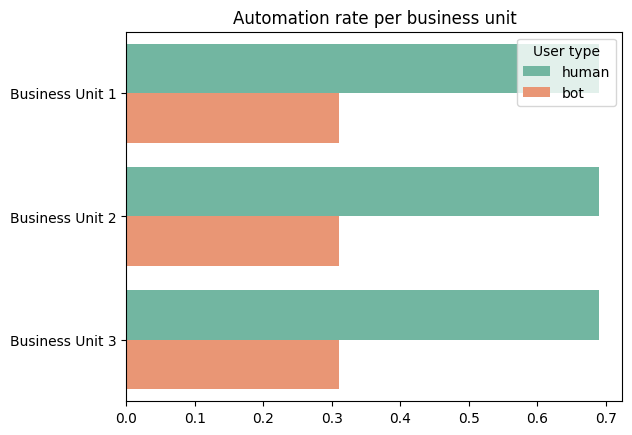

In [192]:
# these results can probably be explained by the fact that the dataset has been generated by ai
auto_bu = df.groupby('Business unit')['User type'].value_counts(normalize=True).round(2)
auto_bu = pd.DataFrame(df.groupby('Business unit')['User type'].value_counts(normalize=True).round(2))
auto_bu.reset_index(inplace=True)
auto_bu.set_index('Business unit', inplace=True)
sns.barplot(data=auto_bu, x='proportion', y='Business unit', hue='User type')
plt.xlabel('')
plt.ylabel('')
plt.title('Automation rate per business unit');

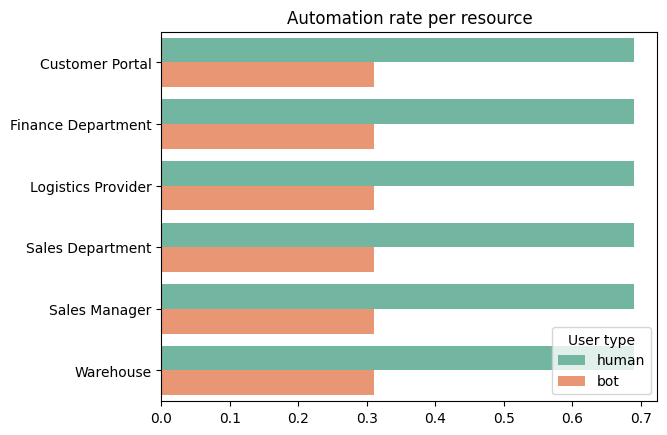

In [193]:
# these results can probably be explained by the fact that the dataset has been generated by ai
auto_dept = df.groupby('Resource')['User type'].value_counts(normalize=True).round(2)
auto_dept = pd.DataFrame(df.groupby('Resource')['User type'].value_counts(normalize=True).round(2))
auto_dept.reset_index(inplace=True)
auto_dept.set_index('Resource', inplace=True)
sns.barplot(data=auto_dept, x='proportion', y='Resource', hue='User type')
plt.xlabel('')
plt.ylabel('')
plt.title('Automation rate per resource');

### Rework

In [138]:
perc_dupl = df['duplicated_process'].sum() / len(df)
print(f"The duplicated processes account for {perc_dupl*100:.2f}% of the total number of processes.")

The duplicated processes account for 6.35% of the total number of processes.


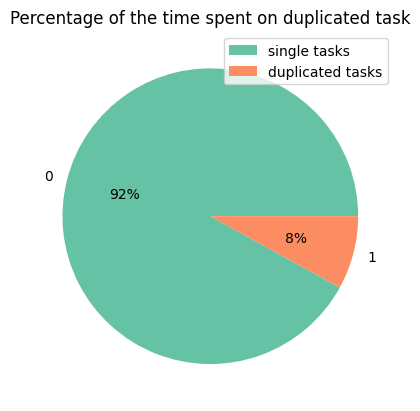

In [194]:
# but accounts for 8% of the time spent
pd.DataFrame(df.groupby('duplicated_process')['duration'].sum()).plot(kind='pie',y='duration', autopct='%1.0f%%')
plt.legend(['single tasks', 'duplicated tasks'])
plt.title("Percentage of the time spent on duplicated task")
plt.ylabel('');

In [146]:
# there are only 2 processes that suffer from duplication
df[df['duplicated_process']==1]['Activity name'].value_counts(normalize=True).mul(100).round(2)

Activity name
Customer Credit Check    66.67
Order Validation         33.33
Name: proportion, dtype: float64

In [147]:
# duplicated tasks are mostly done by human
df[df['duplicated_process']==1]['User type'].value_counts(normalize=True).mul(100).round(2)

User type
human    88.44
bot      11.56
Name: proportion, dtype: float64

In [148]:
# time 'lost' --> streamlining expected
time_lost = df[df['duplicated_process']==1]['duration'].sum()
total_time = df['duration'].sum()
print(f"The company spends {time_lost:,.2f} days in duplicated process ({time_lost/total_time*100:.2f}% of the total time spent in OtoC processes).")

The company spends 110,922.59 days in duplicated process (8.02% of the total time spent in OtoC processes).


### Non compliance

In [177]:
df_order = process_step.process_step_per_order(df,"Case id","Activity name")
df_order.head()

,Case id,Steps
0,Order-1,"[Order Received, Order Validation, Customer Cr..."
1,Order-10,"[Order Received, Order Validation, Customer Cr..."
2,Order-100,"[Order Received, Order Validation, Order Valid..."
3,Order-1000,"[Order Received, Order Validation, Order Confi..."
4,Order-10000,"[Order Received, Order Validation, Customer Cr..."


In [178]:
process_analysis = process_step.compliance_check(df_order, process_flow_ordered)
process_analysis.head()

There are 21 variations of the process.


,Steps,count,Duplicated_steps,Missing_steps,Reversed_steps,Rejected,Compliant,Duplicated,Missing,Reversed
0,"[Order Received, Order Validation, Customer Cr...",12260,0,0,0,0,1,0,0,0
1,"[Order Received, Order Validation, Customer Cr...",8644,0,0,0,1,1,0,1,1
2,"[Order Received, Order Validation, Customer Cr...",8079,0,0,{'values_changed': {'root[6]': {'new_value': '...,0,0,0,0,1
3,"[Order Received, Order Validation, Customer Cr...",6094,0,0,{'values_changed': {'root[3]': {'new_value': '...,0,0,0,0,1
4,"[Order Received, Order Validation, Order Valid...",6056,"[Order Validation, Customer Credit Check]",0,0,0,0,1,0,0


In [179]:
# to do : investigate why these steps are done multiple times
process_step.most_duplicated_steps(process_analysis)

{'Order Validation': 4, 'Customer Credit Check': 4}

In [180]:
# to do : investigate why these steps are skipped
process_step.most_skipped_steps(process_analysis)

{'Customer Credit Check': 4,
 'Send Invoice': 2,
 'Payment Received': 2,
 'Order Completed': 2}

In [182]:
# to do : investigate why these steps are not performed in the correct order
process_step.most_reversed_steps(process_analysis, process_flow_ordered)

{'Send Invoice': 14,
 'Goods Shipped': 12,
 'Order Confirmation Sent': 12,
 'Order Approval': 10,
 'Prepare Goods for Shipment': 8,
 'Payment Received': 8,
 'Customer Credit Check': 4}

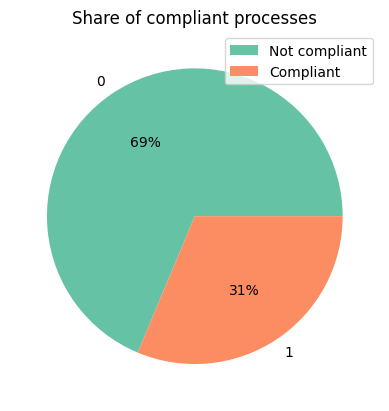

In [195]:
# in total, only 31% of the processes are compliant with the original workflow
process_analysis.groupby('Compliant')['count'].sum().plot(kind='pie',autopct='%1.0f%%').set_title('Share of compliant processes')
plt.legend(['Not compliant', 'Compliant'])
plt.ylabel('');

In [166]:
# the most common mistake is the reversed step (more than half of the cases)
process_analysis.groupby('Reversed')['count'].sum()

Reversed
0    18316
1    48454
Name: count, dtype: int64

In [167]:
process_analysis.groupby('Duplicated')['count'].sum()

Duplicated
0    53037
1    13733
Name: count, dtype: int64

In [168]:
process_analysis.groupby('Missing')['count'].sum()

Missing
0    48080
1    18690
Name: count, dtype: int64

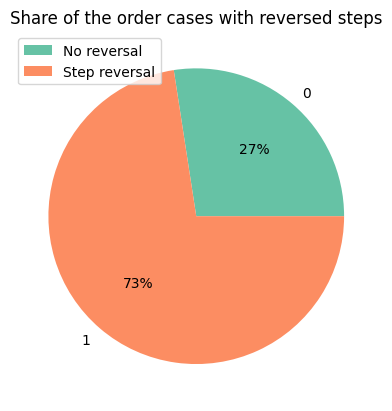

In [196]:
process_analysis.groupby('Reversed')['count'].sum().plot(kind='pie',autopct='%1.0f%%').set_title('Share of the order cases with reversed steps')
plt.legend(['No reversal', 'Step reversal'])
plt.ylabel('');